# Motif Discovery in User Interaction Logs 

### Library Import

In [1]:
import pandas as pd
import numpy as np
import sys

import os

import time # just for dev purpose
from IPython.display import display # Just for displaying DF nicely

from itertools import product

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt

from util.util import *
import util.const
import util.visUtil

### Data Gathering
Read all files in the folder "validation" and the corresponding validation data containing the information about length and distribution of the motifs.

In [ ]:
# ---- Define the path in which all files are stored ----
# folder_path = "../logs/smartRPA/validation/"
# folder_path = "../logs/smartRPA/percentageComparison/"

UILogValidation_filename = "validation_data.csv"
variableLenValidation_filename = "var_len_validation_data.csv"
# percentagData_filename = "validationDataPercentage.csv"

# ---- 50 and 100 Percent p logs ----

folder_path = "../logs/smartRPA/p-50_100_experiment/"
percentagData_filename = "baseline_validation.csv"

# ---- Select all window sizes that should be tested ----
window_sizes = [5,10,15,20,25,30]
window_sizes = [25,50] # 50 and 100 Percent

In [3]:
# Do not change from here
dtypes = util.const.dtype

varLenUILogs = []
UILogs = []
percentageLogs = []

# Getting the relevant files from the folder and sorting them into different lists for processing
for file in os.listdir(folder_path):
    if file.startswith("Log"):
        UILogs.append(file)
    elif file.startswith("Var"):
        varLenUILogs.append(file)
    elif file.startswith("LenLog"):
        percentageLogs.append(file)
    elif file.startswith("Baseline") and file.endswith(".csv"):
        percentageLogs.append(file)

# Read the validation data into two dataframes for processing
try:
    UILogValidationDF = pd.read_csv(folder_path + UILogValidation_filename)
except FileNotFoundError as e:
    print(f"Could not read {UILogValidation_filename} from the folder.\n{e}")

# Check if varliable motif data is present by checking if the var_len_validation_data.csv file exists
try:
    variableLenValidationDF = pd.read_csv(folder_path + variableLenValidation_filename)
    varLenDataAvailable = True
except FileNotFoundError as e:
    print(f"Could not read {variableLenValidation_filename} from the folder.\n{e}")
    varLenDataAvailable = False

# Check if data created for percentage based comparison is available
try:
    percentageValData = pd.read_csv(folder_path + percentagData_filename)
    percentageValAvailable = True
except FileNotFoundError as e:
    print(f"Could not read {percentagData_filename} from the folder.\n{e}")
    percentageValAvailable = False

experimentColumns = ["experimentID","EncodingMethod","uiLogName","variationPercentage","percentageMotifsOverLog","motifLength","windowSize",
                     "windowSizeMatch","motifsToBeDiscovered","motifsDiscovered","numberOfOccurrancesToBeDiscovered",
                     "OccurancesDiscovered/TP","topMotifsT","DiscoveryPercentage","alignmentAccuracy","Precision","Recall","F1-Score","ExecutionTime","executionTimeEncoding","executionTimeDiscovery",
                     "motifSpots","discoveredSpots","DiscoveryLoops"]
experimentResults = pd.DataFrame(columns=experimentColumns)

Could not read validation_data.csv from the folder.
[Errno 2] No such file or directory: 'logs/smartRPA/p-50_100_experiment/validation_data.csv'
Could not read var_len_validation_data.csv from the folder.
[Errno 2] No such file or directory: 'logs/smartRPA/p-50_100_experiment/var_len_validation_data.csv'


## Experiment Setup

1. Create a dataframe to store the experiment results
2. Conduct the experiment for all fixed length files
3. If variable length motifs are created, conduct the experiment for all variable length files

### Percentage Based Discovery

In [4]:
experimentResults = pd.DataFrame(columns=experimentColumns)

for i, log in enumerate(percentageLogs):
    file = pd.read_csv(folder_path + log)
    # Getting the row with the uiLog name from the validation data
    comparisonVariables = percentageValData.loc[percentageValData['uiLogName'] == log]
    # Where the motifs were initially added
    insertSpots = comparisonVariables["motifSpots"]

    # Encode the UI log
    encode_start_time = time.time()
    uiLog = encoding_UiLog(file,encoding=1)
    encode_end_time = time.time()
    encode_time = encode_end_time - encode_start_time
    print(f"UI Log {log} is encoded. {i}/{len(percentageLogs)}.")

    # Where are the motifs actually in the dataframe
    inserted_motif_spots = extract_numbers(insertSpots[insertSpots.index[0]])

    for j, size in enumerate(window_sizes):
        discovery_start_time = time.time()
        experimentId = str(i)+"."+str(j)
        new_row = {'experimentID': experimentId, 'EncodingMethod': "Hierarchy",'uiLogName': log, "variationPercentage": comparisonVariables["variationPercentage"][comparisonVariables.index[0]], 
                   "motifLength": comparisonVariables["motifLength"][comparisonVariables.index[0]], 
                   "windowSize": size, "windowSizeMatch": size-int(comparisonVariables["motifLength"][comparisonVariables.index[0]]),
                   "percentageMotifsOverLog": comparisonVariables["percentageMotifsOverLog"][comparisonVariables.index[0]],
                   "motifsToBeDiscovered": comparisonVariables["motifsToBeDiscovered"][comparisonVariables.index[0]], 
                   "motifsDiscovered": 1, "numberOfOccurrancesToBeDiscovered": comparisonVariables["numberOfOccurrancesToBeDiscovered"][comparisonVariables.index[0]],
                    "motifSpots": inserted_motif_spots}
        
        # Discovery motifs in the dataset
        tm_matrix, event_series = discover_motifs(uiLog, size, normalize=False, self_exclude=True)

        matches_match = True # Do-While Construct with condition checked after each run
        maximalNoOfMatches = 10 # Initiating by looking for t = 10 occurances
        while matches_match: # As long as we have found the same amount of motifs as expected we increase the top motifs value t
            top_motifs = stumpy.motifs(T=event_series, P=tm_matrix[:,0], min_neighbors=1, max_matches=maximalNoOfMatches)
            insert_overlap, motif_overlap, overlapDF = compare_sets(set(inserted_motif_spots), set(top_motifs[1][0]), (size/2))
            matches_match = (len(insert_overlap) >= (maximalNoOfMatches*0.8)) # AS long as Precision > 80% we continue adding to t
            maximalNoOfMatches += 10 # Equals the t value in the paper

        # Correct maximalNoOfMatches for unexecuted round
        maximalNoOfMatches = maximalNoOfMatches - 10
        # Calculate Precision, Recall, and F1-Score
        ground_truth_sum = comparisonVariables["numberOfOccurrancesToBeDiscovered"][comparisonVariables.index[0]]
        true_positives = len(insert_overlap)
        false_positives = maximalNoOfMatches - true_positives  # Incorrectly identified motifs
        false_negatives = ground_truth_sum - true_positives  # Relevant motifs not identified

        # Precision
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0

        # Recall
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

        # F1-Score
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0


        discovery_end_time = time.time()  
        new_row.update({"discoveredSpots": motif_overlap, "OccurancesDiscovered/TP": len(insert_overlap), "topMotifsT": maximalNoOfMatches, 
                        "Precision": precision,"Recall": recall,"F1-Score": f1_score,
                        "ExecutionTime": encode_time + (discovery_end_time - discovery_start_time),
                        "executionTimeEncoding": encode_time,"executionTimeDiscovery": (discovery_end_time - discovery_start_time), "windowSize": size, 
                        "DiscoveryPercentage": len(insert_overlap) / comparisonVariables["numberOfOccurrancesToBeDiscovered"][comparisonVariables.index[0]] * 100,
                        "alignmentAccuracy": overlapDF['alignmentAccuracy'].mean()})
        experimentResults = experimentResults._append(new_row, ignore_index=True)
        

result_file = folder_path + "20250126-experimentResults_precRecF1.csv"
experimentResults.to_csv(result_file)

UI Log Baseline-LenLog_1_vin0_no1_ro100_rlen25_p100_len2500.csv is encoded. 0/24.


C:\Users\tomho\AppData\Local\Temp\ipykernel_19316\874042374.py:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  experimentResults = experimentResults._append(new_row, ignore_index=True)


UI Log Baseline-LenLog_1_vin0_no1_ro100_rlen25_p50_len5000.csv is encoded. 1/24.
UI Log Baseline-LenLog_1_vin0_no1_ro100_rlen50_p100_len5000.csv is encoded. 2/24.
UI Log Baseline-LenLog_1_vin0_no1_ro100_rlen50_p50_len10000.csv is encoded. 3/24.
UI Log Baseline-LenLog_1_vin0_no1_ro10_rlen25_p100_len250.csv is encoded. 4/24.
UI Log Baseline-LenLog_1_vin0_no1_ro10_rlen25_p50_len500.csv is encoded. 5/24.
UI Log Baseline-LenLog_1_vin0_no1_ro10_rlen50_p100_len500.csv is encoded. 6/24.
UI Log Baseline-LenLog_1_vin0_no1_ro10_rlen50_p50_len1000.csv is encoded. 7/24.
UI Log Baseline-LenLog_1_vin0_no1_ro500_rlen25_p100_len12500.csv is encoded. 8/24.
UI Log Baseline-LenLog_1_vin0_no1_ro500_rlen25_p50_len25000.csv is encoded. 9/24.
UI Log Baseline-LenLog_1_vin0_no1_ro500_rlen50_p100_len25000.csv is encoded. 10/24.


C:\Users\tomho\AppData\Local\Temp\ipykernel_19316\874042374.py:4: DtypeWarning: Columns (23,26) have mixed types. Specify dtype option on import or set low_memory=False.
  file = pd.read_csv(folder_path + log)


UI Log Baseline-LenLog_1_vin0_no1_ro500_rlen50_p50_len50000.csv is encoded. 11/24.
UI Log Baseline-LenLog_1_vin0_no2_ro100_rlen25_p100_len2500.csv is encoded. 12/24.
UI Log Baseline-LenLog_1_vin0_no2_ro100_rlen25_p50_len5000.csv is encoded. 13/24.
UI Log Baseline-LenLog_1_vin0_no2_ro100_rlen50_p100_len5000.csv is encoded. 14/24.
UI Log Baseline-LenLog_1_vin0_no2_ro100_rlen50_p50_len10000.csv is encoded. 15/24.
UI Log Baseline-LenLog_1_vin0_no2_ro10_rlen25_p100_len250.csv is encoded. 16/24.
UI Log Baseline-LenLog_1_vin0_no2_ro10_rlen25_p50_len500.csv is encoded. 17/24.
UI Log Baseline-LenLog_1_vin0_no2_ro10_rlen50_p100_len500.csv is encoded. 18/24.
UI Log Baseline-LenLog_1_vin0_no2_ro10_rlen50_p50_len1000.csv is encoded. 19/24.
UI Log Baseline-LenLog_1_vin0_no2_ro500_rlen25_p100_len12500.csv is encoded. 20/24.


C:\Users\tomho\AppData\Local\Temp\ipykernel_19316\874042374.py:4: DtypeWarning: Columns (23,26) have mixed types. Specify dtype option on import or set low_memory=False.
  file = pd.read_csv(folder_path + log)


UI Log Baseline-LenLog_1_vin0_no2_ro500_rlen25_p50_len25000.csv is encoded. 21/24.
UI Log Baseline-LenLog_1_vin0_no2_ro500_rlen50_p100_len25000.csv is encoded. 22/24.


C:\Users\tomho\AppData\Local\Temp\ipykernel_19316\874042374.py:4: DtypeWarning: Columns (23,26) have mixed types. Specify dtype option on import or set low_memory=False.
  file = pd.read_csv(folder_path + log)


UI Log Baseline-LenLog_1_vin0_no2_ro500_rlen50_p50_len50000.csv is encoded. 23/24.


## Visualisation

In [ ]:
# ---- Experiment Visualisation ----
statsData = experimentResults

# Replace with previous statement for continuous experiment processing
# result_file = folder_path + "experimentResultsW20.csv"
# statsData = pd.read_csv(result_file,sep=",") # Used once the file is computed for retrospective visualisation

floatCols = ["variationPercentage","percentageMotifsOverLog","motifLength","windowSize","WindowSizeMatch","motifsToBeDiscovered","motifsDiscovered","numberOfOccurrancesToBeDiscovered",
             "OccurancesDiscovered","DiscoveryPercentage","alignmentAccuracy"]
statsData["DiscoveryPercentage"] = statsData["DiscoveryPercentage"].apply(lambda x: float(x.split()[0].replace(',', '.')))
statsData['alignmentAccuracy'] = statsData['alignmentAccuracy'].str.split('.',n=1).str[0] + "." + statsData['alignmentAccuracy'].str.split('.', n=1).str[1].str.replace('.', '')
for col in floatCols:
    statsData[col] = statsData[col].astype(float)

Index(['experimentID', 'uiLogName', 'variationPercentage',
       'percentageMotifsOverLog', 'motifLength', 'windowSize',
       'windowSizeMatch', 'motifsToBeDiscovered', 'motifsDiscovered',
       'numberOfOccurrancesToBeDiscovered', 'OccurancesDiscovered',
       'DiscoveryPercentage', 'alignmentAccuracy', 'executionTimeEncoding',
       'executionTimeDiscovery', 'motifSpots', 'discoveredSpots',
       'DiscoveryLoops', 'WindowSizeMatch'],
      dtype='object')


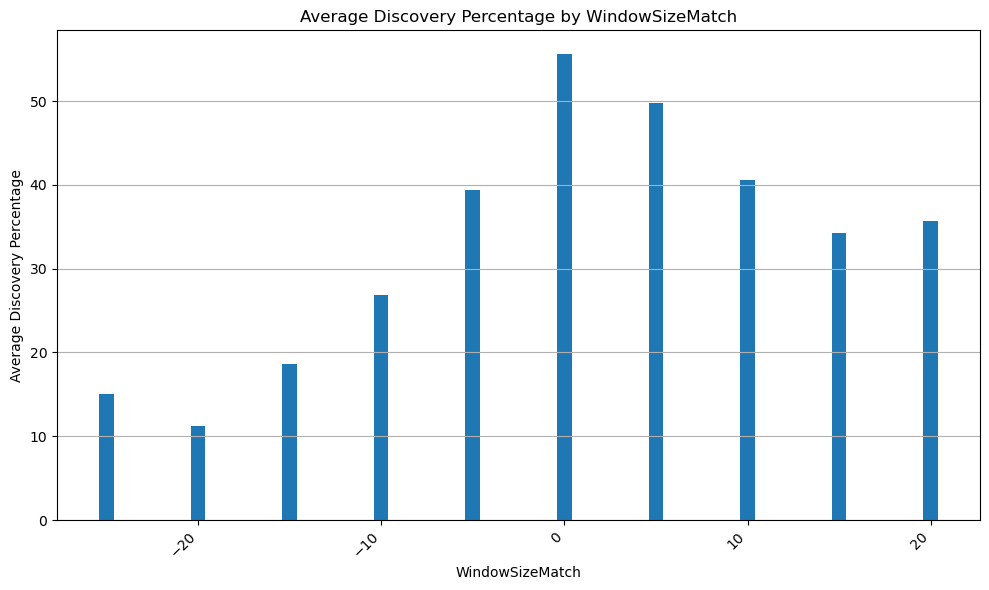

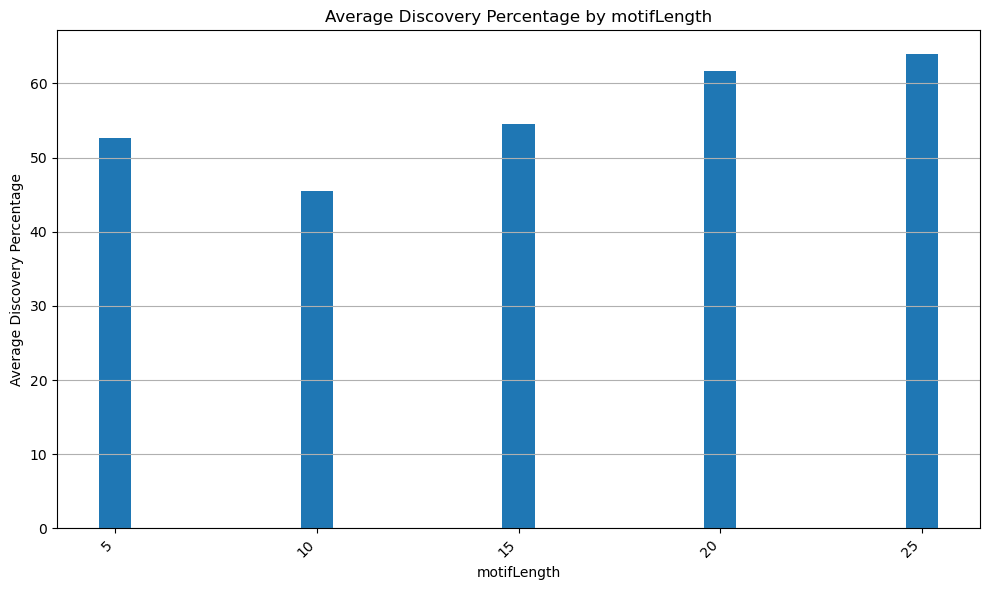

In [6]:
print(statsData.columns)
util.visUtil.plot_discovery_percentage_by_window_size_match(statsData.copy())
util.visUtil.plot_discovery_by_motif_length(statsData.copy())